# **Working with Images & Logistic Regression in PyTorch**

* Working with images in PyTorch (using the MNIST dataset)
* Splitting a dataset into training, validation, and test sets
* Creating PyTorch models with custom logic by extending the nn.Module class
* Interpreting model outputs as probabilities using Softmax and picking predicted labels
* Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification problems
* Setting up a training loop that also evaluates the model using the validation set
* Testing the model manually on randomly picked examples
* Saving and loading model checkpoints to avoid retraining from scratch

# **Working with Images**
We'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: image classification. We'll use the famous [MNIST Handwritten Digits Database](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

We begin by installing and importing `torch` and `torchvision`. `torchvision` contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically.

In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [ ]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [ ]:
# Download training dataset
dataset = MNIST(root='/tmp', download=True)

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the `MNIST` class by passing `train=False` to the constructor.

In [ ]:
test_dataset = MNIST(root='/tmp', train=False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F0C42A42390>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using **`matplotlib`**, the de-facto plotting and graphing library for data science in Python.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement `%matplotlib inline` indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called `magic commands` and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

AttributeError: ignored

Label: 3


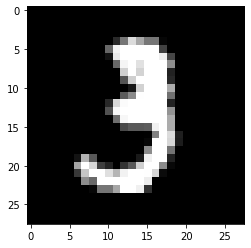

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [ ]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [ ]:
# MNIST dataset (images and labels)
dataset = MNIST(root='/tmp', 
                train=True,
                transform=transforms.ToTensor())

In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [ ]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from `0` to `1`, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

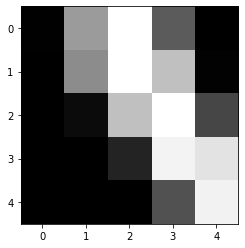

In [ ]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

# **Training and Validation Datasets**
While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.
In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [ ]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

# **Model**
Now that we have prepared our data loaders, we can define our model.

A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is *flattened* into a vector of size 784 `(28*28)` before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [ ]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Let's take a look at the weights and biases.

In [ ]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0306,  0.0233,  0.0246,  ...,  0.0044,  0.0237, -0.0274],
        [-0.0092, -0.0183,  0.0273,  ...,  0.0231,  0.0283,  0.0032],
        [-0.0198,  0.0115, -0.0326,  ..., -0.0211, -0.0331,  0.0023],
        ...,
        [ 0.0266,  0.0023,  0.0052,  ...,  0.0239, -0.0156, -0.0035],
        [ 0.0034,  0.0109, -0.0003,  ...,  0.0134, -0.0133,  0.0085],
        [-0.0272,  0.0239, -0.0254,  ...,  0.0099,  0.0313,  0.0297]],
       requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0277,  0.0082, -0.0131, -0.0247,  0.0122,  0.0338, -0.0122, -0.0082,
         0.0040, -0.0270], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([5, 6, 4, 1, 9, 0, 2, 7, 8, 8, 5, 9, 5, 1, 5, 4, 7, 1, 3, 1, 3, 2, 7, 3,
        0, 7, 1, 2, 1, 2, 9, 2, 7, 1, 1, 7, 0, 0, 4, 0, 4, 9, 0, 9, 9, 3, 7, 4,
        6, 8, 1, 6, 2, 0, 3, 8, 4, 8, 2, 1, 9, 7, 9, 3, 0, 6, 5, 8, 5, 1, 3, 0,
        4, 6, 0, 8, 7, 1, 0, 4, 7, 9, 6, 3, 1, 2, 5, 4, 1, 3, 2, 8, 6, 1, 7, 8,
        0, 6, 8, 3, 6, 4, 4, 8, 7, 0, 0, 5, 6, 6, 2, 7, 7, 1, 4, 6, 3, 8, 0, 8,
        2, 1, 6, 4, 3, 7, 0, 3])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them.

We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data.

In [ ]:
images.reshape(128, 784).shape

torch.Size([128, 784])

To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch.

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [ ]:
class Person:
    # Class constructor
    def __init__(self, name, age):
        # Object properties
        self.name = name
        self.age = age
    
    # Method
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

Here's how we create or *instantiate* an object of the class `Person`.

In [ ]:
bob = Person("Bob", 32)

The object `bob` is an instance of the class `Person`.

We can access the object's properties (also called attributes) or invoke its methods using the `.` notation.

In [ ]:
bob.name, bob.age

('Bob', 32)

In [ ]:
bob.say_hello()

Hello my name is Bob!


Learn more about Python classes here: https://www.w3schools.com/python/python_classes.asp .

Classes can also build upon or *extend* the functionality of existing classes. Let's extend the `nn.Module` class from PyTorch to define a custom model.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [ ]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
# Note: model.linear.weight.shape = torch.Size([10, 784]) 
# because w.t() is used in calculations for the linear regression & logistic regression models:
# (pred = x @ w.t() + b)
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0264, -0.0076, -0.0068,  ..., -0.0199,  0.0054,  0.0025],
         [ 0.0304,  0.0199, -0.0234,  ...,  0.0223, -0.0211,  0.0260],
         [-0.0343, -0.0117, -0.0283,  ...,  0.0232,  0.0105,  0.0316],
         ...,
         [ 0.0256, -0.0222, -0.0334,  ...,  0.0156,  0.0028,  0.0198],
         [ 0.0092,  0.0306,  0.0046,  ...,  0.0264, -0.0040, -0.0034],
         [-0.0013, -0.0005,  0.0187,  ..., -0.0185, -0.0343, -0.0339]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0276, -0.0069, -0.0296, -0.0312, -0.0319,  0.0231,  0.0264,  0.0146,
         -0.0262, -0.0080], requires_grad=True)]

We can use our new custom model in the same way as before. Let's see if it works.

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.2481,  0.1412, -0.1924,  0.0963, -0.2422,  0.3753, -0.0464, -0.0999,
          0.2269, -0.0852],
        [ 0.0330,  0.1835,  0.2651, -0.0865, -0.5237,  0.2584, -0.3970, -0.4463,
          0.2892, -0.0647]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function.

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive.

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

In [ ]:
# Example Softmax Function Application

In [ ]:
sample_arr = torch.tensor([-0.3118, 0.0265, 0.1095, 0.1525, 0.0637, -0.2319, -0.3950, -0.1897, -0.3055, -0.1909])
print(sample_arr)

tensor([-0.3118,  0.0265,  0.1095,  0.1525,  0.0637, -0.2319, -0.3950, -0.1897,
        -0.3055, -0.1909])


In [ ]:
exps = torch.exp(sample_arr)
print(exps)

tensor([0.7321, 1.0269, 1.1157, 1.1647, 1.0658, 0.7930, 0.6737, 0.8272, 0.7368,
        0.8262])


In [ ]:
probs = exps / torch.sum(exps)
print(probs)

tensor([0.0817, 0.1146, 0.1245, 0.1300, 0.1189, 0.0885, 0.0752, 0.0923, 0.0822,
        0.0922])


In [ ]:
print(torch.sum(probs))

tensor(1.0000)


We'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case)

In [ ]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package and requires us to specify a dimension along which the function should be applied.

In [ ]:
print(outputs.shape)
outputs[:2]

torch.Size([128, 10])


tensor([[-0.2481,  0.1412, -0.1924,  0.0963, -0.2422,  0.3753, -0.0464, -0.0999,
          0.2269, -0.0852],
        [ 0.0330,  0.1835,  0.2651, -0.0865, -0.5237,  0.2584, -0.3970, -0.4463,
          0.2892, -0.0647]], grad_fn=<SliceBackward>)

In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0770, 0.1137, 0.0814, 0.1087, 0.0775, 0.1437, 0.0942, 0.0893, 0.1239,
         0.0906],
        [0.1041, 0.1210, 0.1313, 0.0924, 0.0597, 0.1304, 0.0677, 0.0645, 0.1345,
         0.0944]])
Sum:  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each row's largest element and the corresponding index.

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([5, 8, 5, 5, 3, 0, 8, 1, 7, 3, 0, 1, 5, 8, 6, 5, 5, 8, 1, 1, 1, 5, 8, 5,
        5, 1, 1, 5, 5, 3, 5, 1, 1, 1, 5, 5, 5, 5, 5, 2, 8, 5, 8, 5, 1, 8, 1, 2,
        5, 4, 5, 7, 1, 8, 5, 5, 6, 3, 0, 5, 3, 5, 3, 5, 5, 1, 3, 5, 5, 5, 5, 8,
        2, 0, 5, 2, 2, 5, 2, 8, 8, 3, 5, 7, 8, 1, 1, 3, 5, 8, 5, 2, 5, 2, 5, 1,
        0, 3, 3, 8, 8, 5, 5, 5, 6, 7, 5, 3, 5, 6, 3, 8, 2, 5, 5, 0, 5, 6, 5, 5,
        5, 5, 5, 1, 3, 6, 5, 1])
tensor([0.1437, 0.1345, 0.1279, 0.1829, 0.1101, 0.1310, 0.1241, 0.1126, 0.1254,
        0.1271, 0.1163, 0.1219, 0.1243, 0.1348, 0.1127, 0.1386, 0.1286, 0.1373,
        0.1332, 0.1365, 0.1339, 0.1287, 0.1223, 0.1339, 0.1433, 0.1200, 0.1291,
        0.1213, 0.1234, 0.1317, 0.1179, 0.1315, 0.1409, 0.1423, 0.1258, 0.1249,
        0.1361, 0.1344, 0.1170, 0.1279, 0.1251, 0.1219, 0.1242, 0.1311, 0.1535,
        0.1140, 0.1431, 0.1496, 0.1500, 0.1213, 0.1416, 0.1320, 0.1253, 0.1367,
        0.1220, 0.1466, 0.1207, 0.1193, 0.1143, 0.1427, 0.1149, 0.1331, 0.1309,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [ ]:
labels

tensor([5, 5, 8, 5, 1, 2, 2, 3, 2, 6, 1, 3, 6, 9, 1, 8, 9, 6, 6, 0, 0, 7, 7, 8,
        5, 1, 6, 3, 4, 6, 4, 2, 0, 2, 4, 9, 5, 8, 3, 7, 7, 6, 7, 6, 0, 9, 6, 0,
        8, 7, 9, 5, 5, 7, 6, 8, 5, 5, 1, 9, 7, 4, 8, 7, 6, 0, 8, 9, 0, 2, 5, 9,
        5, 1, 8, 3, 7, 5, 9, 1, 1, 3, 9, 9, 2, 8, 0, 4, 7, 9, 3, 2, 5, 7, 4, 2,
        8, 6, 9, 2, 7, 4, 2, 4, 2, 6, 6, 7, 5, 1, 2, 2, 3, 0, 1, 1, 5, 1, 4, 9,
        6, 5, 8, 8, 9, 8, 7, 2])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

# **Evaluation Metric and Loss Function**
Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions.

In [ ]:
outputs[:2]

tensor([[-0.2481,  0.1412, -0.1924,  0.0963, -0.2422,  0.3753, -0.0464, -0.0999,
          0.2269, -0.0852],
        [ 0.0330,  0.1835,  0.2651, -0.0865, -0.5237,  0.2584, -0.3970, -0.4463,
          0.2892, -0.0647]], grad_fn=<SliceBackward>)

In [ ]:
torch.sum(preds == labels)

tensor(13)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [ ]:
accuracy(outputs, labels)

tensor(0.1016)

In [ ]:
probs

tensor([[0.0770, 0.1137, 0.0814,  ..., 0.0893, 0.1239, 0.0906],
        [0.1041, 0.1210, 0.1313,  ..., 0.0645, 0.1345, 0.0944],
        [0.0760, 0.1086, 0.1045,  ..., 0.0969, 0.1018, 0.0771],
        ...,
        [0.1041, 0.0929, 0.1004,  ..., 0.1108, 0.0984, 0.0828],
        [0.0884, 0.0976, 0.1008,  ..., 0.1067, 0.1009, 0.0796],
        [0.0984, 0.1196, 0.0791,  ..., 0.1067, 0.1064, 0.1000]],
       grad_fn=<SoftmaxBackward>)

Accuracy is an excellent way for us to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is **cross-entropy**.
* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the logarithm of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [ ]:
outputs

tensor([[-0.2481,  0.1412, -0.1924,  ..., -0.0999,  0.2269, -0.0852],
        [ 0.0330,  0.1835,  0.2651,  ..., -0.4463,  0.2892, -0.0647],
        [-0.2819,  0.0757,  0.0367,  ..., -0.0384,  0.0107, -0.2670],
        ...,
        [ 0.0268, -0.0879, -0.0099,  ...,  0.0888, -0.0298, -0.2031],
        [-0.1858, -0.0866, -0.0550,  ...,  0.0021, -0.0541, -0.2912],
        [-0.0715,  0.1235, -0.2900,  ...,  0.0091,  0.0063, -0.0552]],
       grad_fn=<AddmmBackward>)

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3457, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number `e.g. 2.23` is look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. `The lower the loss, The better the model.`

# **Training the model**
Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

    for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection

Some parts of the training loop are specific to the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        # Models called here are defined below and in updated MnistModel class definition
        # Training Phase 
        for batch in train_loader:
            # Generate Predictions
            # Calculate Loss
            loss = model.training_step(batch)
            # Compute Gradients
            loss.backward()
            # Update Weights
            optimizer.step()
            # Reset Gradients
            optimizer.zero_grad()
        
        # Validation phase
          # Generate Predictions
          # Calculate Loss
          # Calculate Metrics (ex: accuracy)
        result = evaluate(model, val_loader)
          # Log epoch, loss, metrics for inspection
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the `evaluate` function, used in the validation phase of `fit`.

In [ ]:
l1 = [1, 2, 3, 4, 5]

In [ ]:
# function and for loop notation example, used in evaluate method definition
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [ ]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.08455300331115723, 'val_loss': 2.36184024810791}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9771, val_acc: 0.5756
Epoch [1], val_loss: 1.7027, val_acc: 0.7051
Epoch [2], val_loss: 1.4980, val_acc: 0.7492
Epoch [3], val_loss: 1.3436, val_acc: 0.7718
Epoch [4], val_loss: 1.2249, val_acc: 0.7867


Try changing the learning rates and number of epochs in each of the cells below.

In [ ]:
history2 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1319, val_acc: 0.7983
Epoch [1], val_loss: 1.0573, val_acc: 0.8080
Epoch [2], val_loss: 0.9963, val_acc: 0.8147
Epoch [3], val_loss: 0.9456, val_acc: 0.8207
Epoch [4], val_loss: 0.9028, val_acc: 0.8257
Epoch [5], val_loss: 0.8661, val_acc: 0.8291
Epoch [6], val_loss: 0.8343, val_acc: 0.8329
Epoch [7], val_loss: 0.8066, val_acc: 0.8352
Epoch [8], val_loss: 0.7821, val_acc: 0.8385
Epoch [9], val_loss: 0.7603, val_acc: 0.8404


In [ ]:
history3 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7582, val_acc: 0.8403
Epoch [1], val_loss: 0.7562, val_acc: 0.8405
Epoch [2], val_loss: 0.7542, val_acc: 0.8407
Epoch [3], val_loss: 0.7522, val_acc: 0.8408
Epoch [4], val_loss: 0.7502, val_acc: 0.8413


In [ ]:
history4 = fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7483, val_acc: 0.8415
Epoch [1], val_loss: 0.7464, val_acc: 0.8417
Epoch [2], val_loss: 0.7445, val_acc: 0.8418
Epoch [3], val_loss: 0.7426, val_acc: 0.8419
Epoch [4], val_loss: 0.7407, val_acc: 0.8420
Epoch [5], val_loss: 0.7389, val_acc: 0.8423
Epoch [6], val_loss: 0.7370, val_acc: 0.8426
Epoch [7], val_loss: 0.7352, val_acc: 0.8427
Epoch [8], val_loss: 0.7334, val_acc: 0.8428
Epoch [9], val_loss: 0.7317, val_acc: 0.8431


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

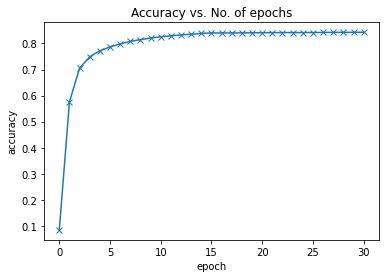

In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture **non-linear relationships** between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.

# **Testing with individual images**

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [ ]:
# Define test dataset
test_dataset = MNIST(root='/tmp', 
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

Shape: torch.Size([1, 28, 28])
Label: 7


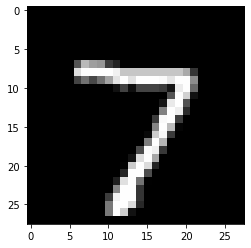

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
# img[0] representation as a tensor:
print(img)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

Label: 7 , Predicted: 7


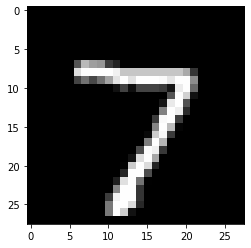

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


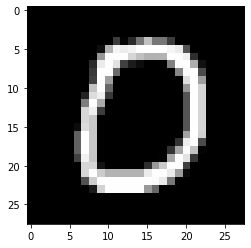

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


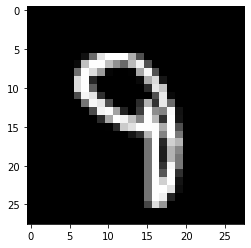

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


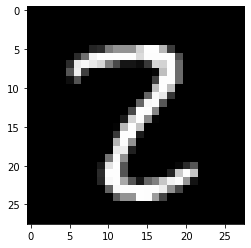

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.855664074420929, 'val_loss': 0.6948556303977966}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

# **Saving and loading the model**

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0133,  0.0008, -0.0201,  ...,  0.0247,  0.0329, -0.0165],
                      [-0.0028, -0.0225, -0.0141,  ..., -0.0338,  0.0121,  0.0186],
                      [-0.0127, -0.0274,  0.0350,  ...,  0.0053,  0.0195, -0.0153],
                      ...,
                      [ 0.0285,  0.0035, -0.0177,  ...,  0.0104,  0.0307,  0.0290],
                      [-0.0246,  0.0200, -0.0033,  ...,  0.0119, -0.0220, -0.0070],
                      [ 0.0193,  0.0011,  0.0185,  ...,  0.0274, -0.0034, -0.0234]])),
             ('linear.bias',
              tensor([-0.0675,  0.0876, -0.0487,  0.0125,  0.0255,  0.0545,  0.0247,  0.0632,
                      -0.0495,  0.0056]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [ ]:
# initialize a second model (with randomly generated weights)
model2 = MnistModel()

In [ ]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0230,  0.0332,  0.0038,  ..., -0.0109, -0.0273, -0.0320],
                      [ 0.0192, -0.0146, -0.0112,  ..., -0.0277,  0.0278, -0.0191],
                      [ 0.0201,  0.0286, -0.0059,  ..., -0.0295,  0.0237, -0.0221],
                      ...,
                      [ 0.0266, -0.0316,  0.0034,  ..., -0.0353,  0.0203, -0.0261],
                      [-0.0281, -0.0148, -0.0225,  ...,  0.0103, -0.0347, -0.0219],
                      [ 0.0197, -0.0002, -0.0331,  ...,  0.0286,  0.0229, -0.0203]])),
             ('linear.bias',
              tensor([ 0.0287,  0.0093, -0.0016,  0.0071, -0.0337,  0.0192, -0.0131, -0.0111,
                      -0.0039,  0.0036]))])

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.09833984076976776, 'val_loss': 2.2978012561798096}

In [ ]:
# loading the original (trained) model into the recently instantiated second model
# Note: linear.weight and linear.bias have the same respective tensor values as the trained model before saving
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0133,  0.0008, -0.0201,  ...,  0.0247,  0.0329, -0.0165],
                      [-0.0028, -0.0225, -0.0141,  ..., -0.0338,  0.0121,  0.0186],
                      [-0.0127, -0.0274,  0.0350,  ...,  0.0053,  0.0195, -0.0153],
                      ...,
                      [ 0.0285,  0.0035, -0.0177,  ...,  0.0104,  0.0307,  0.0290],
                      [-0.0246,  0.0200, -0.0033,  ...,  0.0119, -0.0220, -0.0070],
                      [ 0.0193,  0.0011,  0.0185,  ...,  0.0274, -0.0034, -0.0234]])),
             ('linear.bias',
              tensor([-0.0675,  0.0876, -0.0487,  0.0125,  0.0255,  0.0545,  0.0247,  0.0632,
                      -0.0495,  0.0056]))])

Let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.855664074420929, 'val_loss': 0.6948556303977966}

Additional Resources

* [FastAI](https://github.com/fastai/fastai_dev/blob/master/dev_nb/001a_nn_basics.ipynb)
* [Blog Post on DeepNotes](https://deepnotes.io/softmax-crossentropy)